### Melenoma Detection using deep learning

## Problem Statement:

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant. The data set contains the following diseases:
Actinic keratosis
Basal cell carcinoma
Dermatofibroma
Melanoma
Nevus
Pigmented benign keratosis
Seborrheic keratosis
Squamous cell carcinoma
Vascular lesion


##The notebook consists of the following:

- Data reading/understanding




1.   Importing all the important libraries






- Creating a dataset


1.   Defining some parameters for the loader
2.   creating a training dataset
3.   creating a test dataset


- Visualize the data
- Create the model 1
- Compiling the model 1
- Training the model 1
- visualizing the train vs validation accuracy & train vs validation loss for Model 1
- resolve overfitting
- Create the model 2
- Compiling the model 2
- Training the model 2
- visualizing the train vs validation accuracy & train vs validation loss for Model 2
- Rectify the class imbalance
-distribution of augmented data after adding new images to the original training data
-Train the model on the data created using Augmentor
1.   Defining some parameters for the loader
2.   creating a training dataset
3.   creating a test dataset

- Create the final model
- visualizing the train vs validation accuracy & train vs validation loss for final Model




# Data reading/understanding:

#### Importing all the important libraries

In [18]:
## Importing the neccessary libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout,BatchNormalization
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [19]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [22]:
##counting the number of Train and Test images

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
113


## Creating a Dataset


Defining some parameters for the loader:


In [23]:
## Defining parameters for the loader
batch_size = 32 #represents the number of samples used in one forward and backward pass through the network
img_height = 180  #height of the image
img_width = 180  #width of the image

#### Using 80% of the images for training, and 20% for validation.

creating a training dataset

In [24]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


creating a testing dataset

In [25]:

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [26]:
#Listing out the classes of skin cancer and store them in a list
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


##Visualize the data

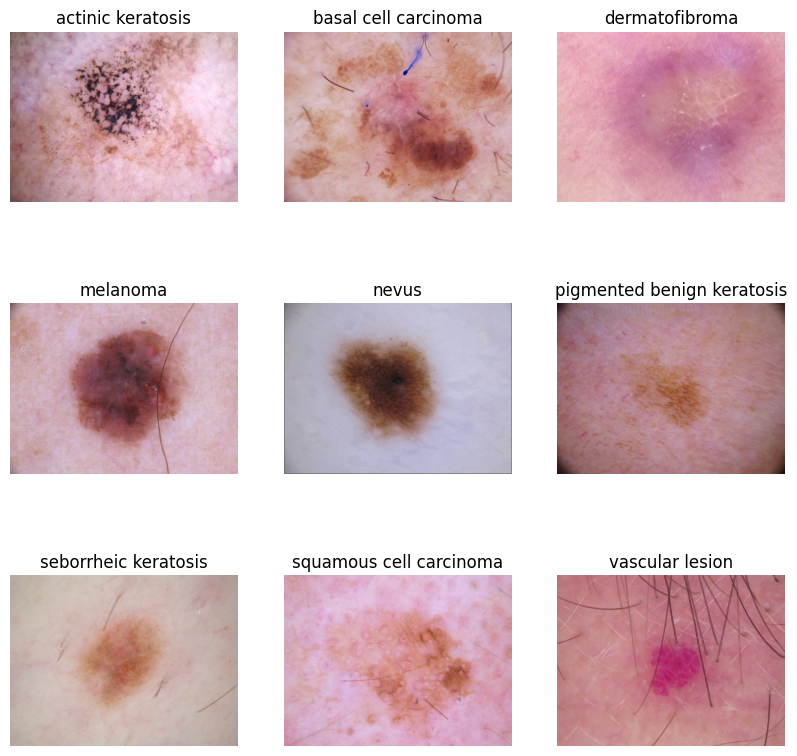

In [27]:

#Plotting images of train data side by side
#we are only displaying 9 images 3 in each row

plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  image = plt.imread(str(list(data_dir_train.glob(f'{class_names[i]}/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)
  plt.axis('off')

#### The dataset:
The `**image_batch**` contains 32 images, each sized 180x180 pixels with RGB color channels. The `**label_batch**` comprises 32 corresponding labels identifying the category of each image, forming a dataset for model training.

### Optimizing data loading and processing for model building and training
Caching and prefetching the data improves the efficiency of data loading and processing during model training.

In [28]:

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

##Create the model 1
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [29]:
## creating the first model

# using an Sequential model
model = Sequential()
# we have to rescale values between 0 and 1
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))
# adding max pooling to reduce spatial dimensions
model.add(Conv2D(16, kernel_size=(3, 3),padding='same', activation='relu'))
model.add(MaxPool2D(pool_size = (2,2)))
#maxpool takes the maximum value in a particular matrix
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2,2)))

# applying the flattening so that we can give to fully connected layers
model.add(Flatten())

# here Dense means its a fully connected layer
model.add(Dense(128,activation='relu'))

# for the output layer we are using softmax beacuse our output contains more than one class which is multiclass classification
model.add(Dense(9,activation='softmax'))

### Compiling the model 1

In [30]:
# we are using an adam optimizer because it reduces the loss function while training the neural networks
# SparseCategoricalCrossentropy is used for representing as a single index value rather than a one-hot encoded vector
# Accuracy metric to track during training
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [31]:
# summary shows us all the output shape and parameters used
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

##Training the model 1

In [32]:

epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 384s 2s/step - loss: 2.0934 - accuracy: 0.2165 - val_loss: 2.0412 - val_accuracy: 0.2841
Epoch 2/20
56/56 [==============================] - 60s 1s/step - loss: 1.7382 - accuracy: 0.3867 - val_loss: 1.5883 - val_accuracy: 0.4497
Epoch 3/20
56/56 [==============================] - 76s 1s/step - loss: 1.4509 - accuracy: 0.4939 - val_loss: 1.4892 - val_accuracy: 0.5034
Epoch 4/20
56/56 [==============================] - 64s 1s/step - loss: 1.3198 - accuracy: 0.5368 - val_loss: 1.3732 - val_accuracy: 0.5302
Epoch 5/20
56/56 [==============================] - 71s 1s/step - loss: 1.1907 - accuracy: 0.5809 - val_loss: 1.3085 - val_accuracy: 0.5459
Epoch 6/20
56/56 [==============================] - 82s 1s/step - loss: 1.1550 - accuracy: 0.5871 - val_loss: 1.6145 - val_accuracy: 0.4855
Epoch 7/20
56/56 [==============================] - 74s 1s/step - loss: 1.0794 - accuracy: 0.6205 - val_loss: 1.4230 - val_accuracy: 0.5235
Epoch 8/20
56/56 [=

visualizing the train vs validation accuracy & train vs validation loss for Model 1

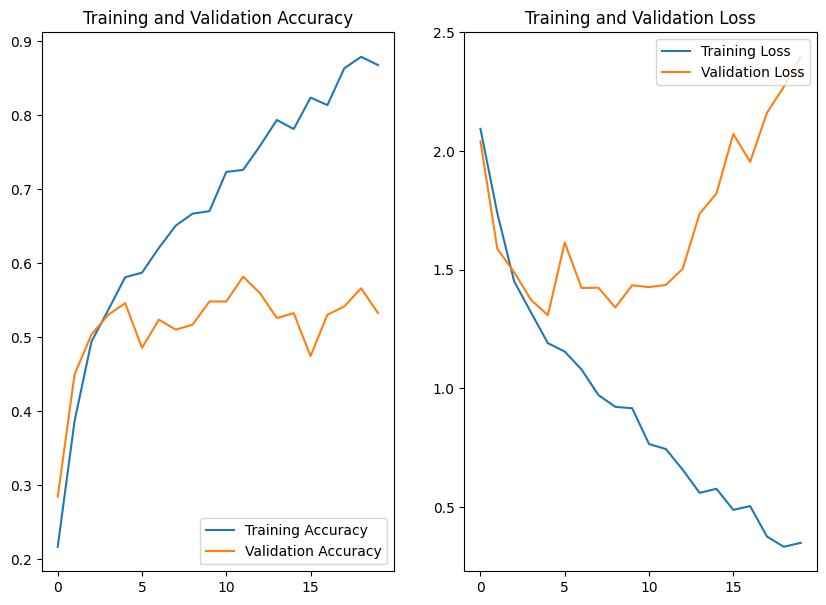

In [33]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

## Ploting the train vs validation accuracy
plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Ploting the  train vs validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit
- The training accuracy in the first image which is the blue line is very high around 90% accuracy whereas the validation accuracy is very low  around 50-60% which tells us that the model is overfitting.
- Similarly the validation loss is going up while the training loss is going down which are going in two opposite directions.

In [ ]:
#  after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

## Resolving the overfitting

Data Augmentation is the process of artificially generating new data from existing data, primarily to train new machine learning models.The images will create a bigger dataset that will generalize in a better manner to situations that the model could encounter in production.

In [34]:
# in order to use augmentation we are using sequential model
data_augmentation = keras.Sequential([
    # flips the images horizontally
    layers.RandomFlip("horizontal"),
    # rotates the image by 0.1
    layers.RandomRotation(0.1),
    # zooming the image by 0.1
    layers.RandomZoom(0.1),
    # adjusting the brightness levels by 0.1
    layers.RandomContrast(0.1)
])

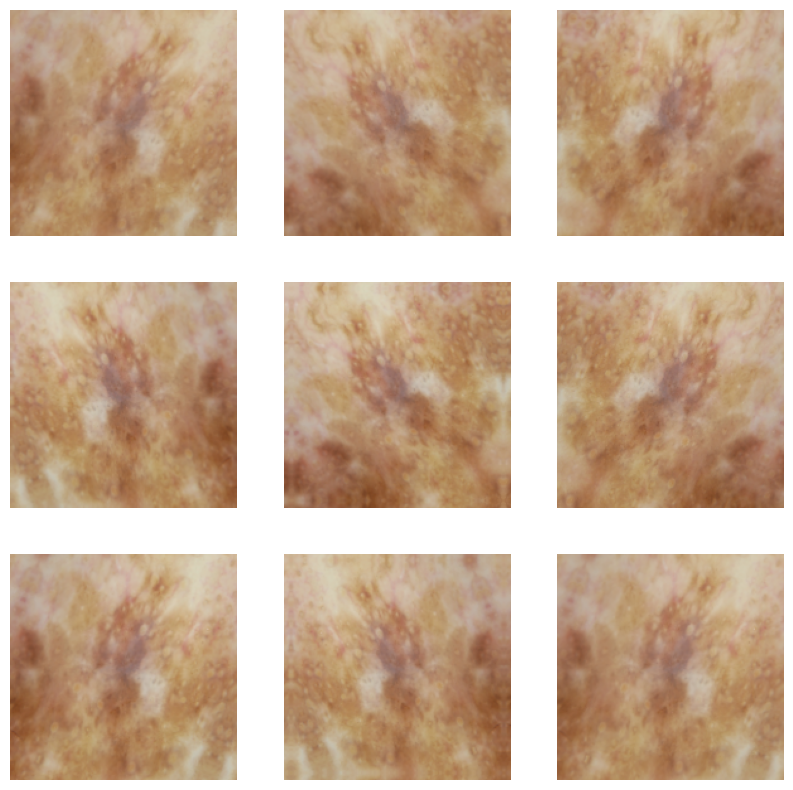

In [35]:
##visualizing how our augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Create the model 2


In [36]:
## we are now defining the second model where we are using the data augumentaion

# using an Sequential model
model = Sequential()

# # we have to rescale values between 0 and 1
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))

# Apply data augmentation to reduce overfitting
model.add(data_augmentation)
# # adding max pooling to reduce spatial dimensions
#maxpool takes the maximum value in a particular matrix
model.add(Conv2D(32, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=(3, 3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# # applying the flattening so that we can give to fully connected layers
model.add(Flatten())

# here Dense means its a fully connected layer
model.add(Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))

# for the output layer we are using softmax beacuse our output contains more than one class which is multiclass classification
model.add(Dense(9, activation='softmax'))

### Compiling the model 2




In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [38]:
# summary shows us all the output shape and parameters used
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 64)        18496     
                                                      

### Training the model 2

In [39]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 159s 3s/step - loss: 2.4221 - accuracy: 0.1735 - val_loss: 2.0711 - val_accuracy: 0.2215
Epoch 2/20
56/56 [==============================] - 148s 3s/step - loss: 1.9699 - accuracy: 0.2779 - val_loss: 1.8800 - val_accuracy: 0.3177
Epoch 3/20
56/56 [==============================] - 149s 3s/step - loss: 1.8173 - accuracy: 0.3248 - val_loss: 1.6583 - val_accuracy: 0.4161
Epoch 4/20
56/56 [==============================] - 155s 3s/step - loss: 1.6703 - accuracy: 0.4074 - val_loss: 1.6862 - val_accuracy: 0.4452
Epoch 5/20
56/56 [==============================] - 149s 3s/step - loss: 1.6176 - accuracy: 0.4196 - val_loss: 1.5509 - val_accuracy: 0.4720
Epoch 6/20
56/56 [==============================] - 147s 3s/step - loss: 1.5277 - accuracy: 0.4570 - val_loss: 1.4805 - val_accuracy: 0.5011
Epoch 7/20
56/56 [==============================] - 149s 3s/step - loss: 1.5093 - accuracy: 0.4626 - val_loss: 1.6766 - val_accuracy: 0.4094
Epoch 8/20
56

visualizing the train vs validation accuracy & train vs validation loss for Model 2

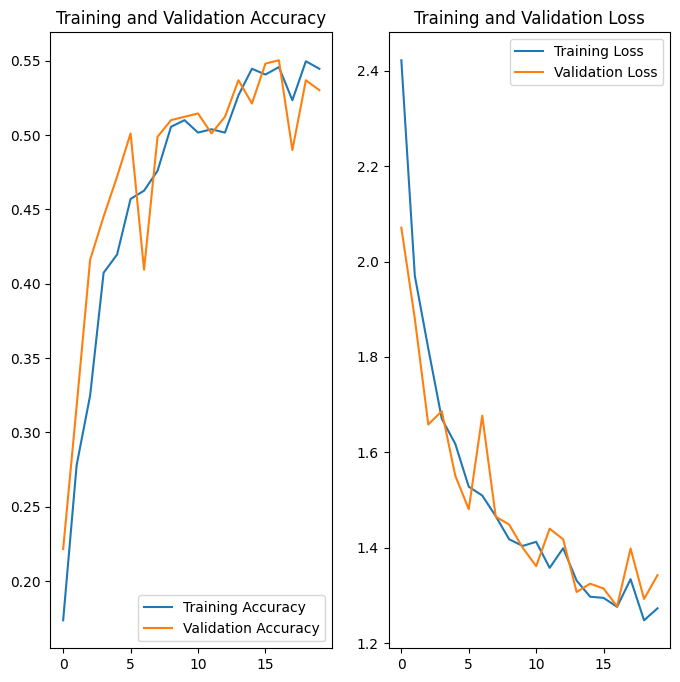

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
#Ploting the train vs validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
#Ploting  train vs validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?
- But we can see the overfitting is reducing beacuse of data augmentation we have performed.
- we also observe a decline in the training accuracy has decreased to 55%  due to the presence of class imbalance in the data.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

calculating the number of images in each class

In [41]:

# Create an empty list to store dictionaries
class_diff_data = []

# Iterate through each class name
for name in class_names:
    number = len(list(data_dir_train.glob(f'{name}/*.jpg')))  # Count the number of images in the class

    # Append the class name and the number of images as a dictionary to the list
    class_diff_data.append({'class': name, 'number': number})

# Create a DataFrame from the list of dictionaries
class_diff = pd.DataFrame(class_diff_data)

# Display the DataFrame of class and number
class_diff

,class,number
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


<function matplotlib.pyplot.show(close=None, block=None)>

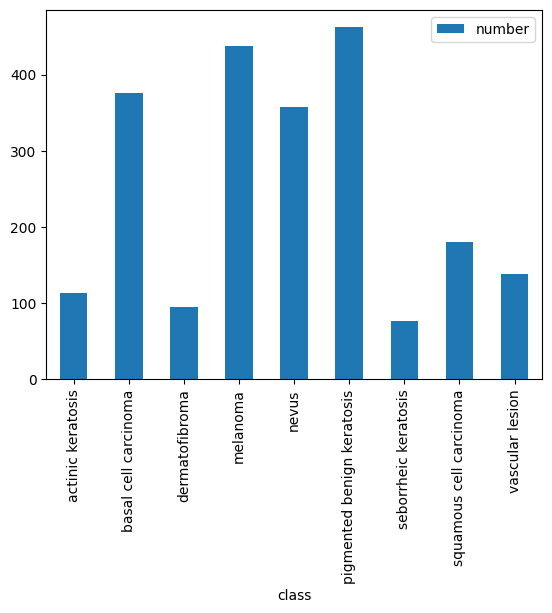

In [42]:
## representing all the disease in a barplot form to see which has higher number of samples.
class_diff.plot.bar(x='class',y='number')
plt.show

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?
* The least number of samples from above bar graph is  **seborrheic keratosis**
* There are 4 types of classes which dominate each other in terms of proportionate number of samples


   1.   actic keratosis and dermatafibroma
   2.   melanoma and pigmented benign keratosis


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [43]:
## Number of images in the original dataset
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [44]:
## Creating dataframe with the path and label for the orginal dataset
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/drive/MyDrive/CNN_assignment/Skin can...,melanoma
1,/content/drive/MyDrive/CNN_assignment/Skin can...,melanoma
2,/content/drive/MyDrive/CNN_assignment/Skin can...,melanoma
3,/content/drive/MyDrive/CNN_assignment/Skin can...,melanoma
4,/content/drive/MyDrive/CNN_assignment/Skin can...,melanoma
...,...,...
2234,/content/drive/MyDrive/CNN_assignment/Skin can...,vascular lesion
2235,/content/drive/MyDrive/CNN_assignment/Skin can...,vascular lesion
2236,/content/drive/MyDrive/CNN_assignment/Skin can...,vascular lesion
2237,/content/drive/MyDrive/CNN_assignment/Skin can...,vascular lesion


In [45]:
## Number of sdample in the original dataset before generation of augmented images
original_df['Label'].value_counts()

Label
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

#### `**Class imbalance handling approach**`:
We are using a python package called Augmentor to generate and add more samples across the classes so that none of the classes will have too little samples to off-set the balance of the dataset. Augmentor generates more images after stochastically augmenting them with operations like rotation, cropping, etc.

In [46]:
!pip install Augmentor

In [47]:

import Augmentor
path_to_training_dataset=data_dir_train

for class_name in class_names:
    p = Augmentor.Pipeline((path_to_training_dataset / class_name).as_posix())
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D89CE1679A0>: 100%|██████████| 500/500 [00:29<00:00, 16.87 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D89CE1B3D90>: 100%|██████████| 500/500 [00:30<00:00, 16.63 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D89CF9F9ED0>: 100%|██████████| 500/500 [00:25<00:00, 19.66 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=771x750 at 0x7D89D5ED5540>: 100%|██████████| 500/500 [01:44<00:00,  4.77 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=962x722 at 0x7D89D66D6500>: 100%|██████████| 500/500 [01:53<00:00,  4.42 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D89CE00FC70>: 100%|██████████| 500/500 [00:24<00:00, 20.51 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D89CFAC6E60>: 100%|██████████| 500/500 [00:47<00:00, 10.42 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D89D5908640>: 100%|██████████| 500/500 [00:23<00:00, 21.19 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7D89D5ED4EE0>: 100%|██████████| 500/500 [00:24<00:00, 20.09 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types. We will now take a look at total count of augmented images.

In [48]:
## Calculating the total count of augmented images
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


###  Lets see the distribution of augmented data after adding new images to the original training data.

In [49]:
## gives the path of all new images
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000150.jpg_7c41e0fa-c490-4d6c-bc52-7691dc8549b7.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000296.jpg_378db58f-3d4f-4db4-b6e4-4c13f8de1768.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010610.jpg_6b40cd06-5f80-45ef-a3b2-47e0ee411274.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010808.jpg_4acf5b33-213b-418f-ba80-14d8f4ec3068.jpg',
 '/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010394.jpg_651b0b15-7909-454c-ac18-b87182f76

In [50]:
## Creating a list which has all the labesls in the dataset
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [51]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [52]:
## Creating a dataframe df2 containing the path and label of all the augmented images
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# Concatenating df2 to original_df
new_df = pd.concat([original_df, df2], ignore_index=True)

In [53]:
## so this gives us the value count that means how many numbers for each disease
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64


- So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

##Train the model on the data created using Augmentor


In [54]:

batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [55]:
## Training set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [56]:
## Validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [57]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Creating a final Model

In [58]:

# using an Sequential model
model = Sequential()

# Rescaling the values between 0 and 1
model.add(layers.Rescaling(1./255,input_shape=(img_height, img_width,3)))

# using maxpool to reduce overfitting which chooses max value in a matrix
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Conv2D(256,kernel_size=(11,11),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))

# performing flattening so that we can gice it to fully connected layers
model.add(layers.Flatten())

# dropout helps us in reducing overfitting
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.25))

# for the output layer we are using softmax beacuse our output contains more than one class which is multiclass classification
model.add(layers.Dense(9,activation='softmax'))

In [59]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [60]:
# View the summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 128)      

In [61]:
## Training the final model for 30 epochs
epochs = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 734s 4s/step - loss: 2.1426 - accuracy: 0.1615 - val_loss: 2.0125 - val_accuracy: 0.2123
Epoch 2/30
169/169 [==============================] - 655s 4s/step - loss: 1.9534 - accuracy: 0.2233 - val_loss: 1.7232 - val_accuracy: 0.3430
Epoch 3/30
169/169 [==============================] - 666s 4s/step - loss: 1.7361 - accuracy: 0.3277 - val_loss: 1.6036 - val_accuracy: 0.3831
Epoch 4/30
169/169 [==============================] - 673s 4s/step - loss: 1.5969 - accuracy: 0.3680 - val_loss: 1.5099 - val_accuracy: 0.4395
Epoch 5/30
169/169 [==============================] - 607s 4s/step - loss: 1.5275 - accuracy: 0.3986 - val_loss: 1.3845 - val_accuracy: 0.4543
Epoch 6/30
169/169 [==============================] - 592s 4s/step - loss: 1.5014 - accuracy: 0.4097 - val_loss: 1.3850 - val_accuracy: 0.4744
Epoch 7/30
169/169 [==============================] - 593s 4s/step - loss: 1.4275 - accuracy: 0.4323 - val_loss: 1.2934 - val_accuracy: 0.5041

visualizing the train vs validation accuracy & train vs validation loss for Final Model

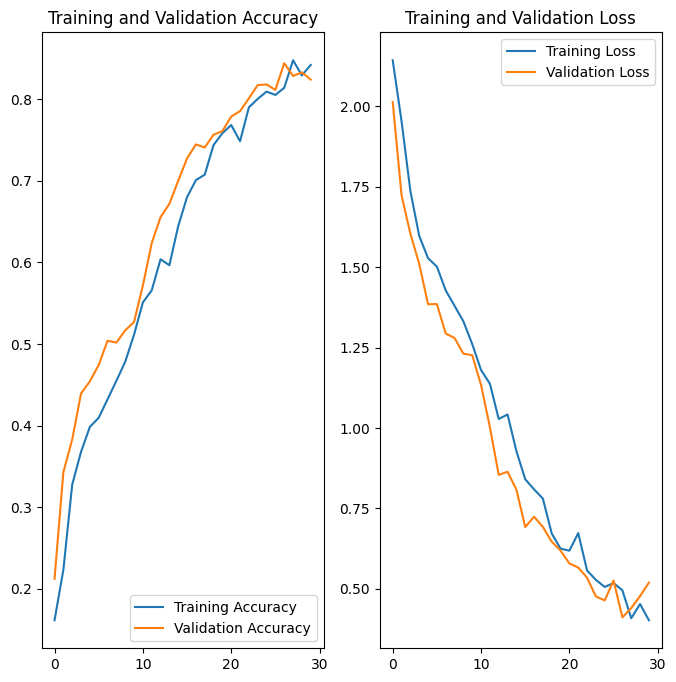

In [62]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

#Ploting the train vs validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#Ploting the train vs validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

####Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?


The model which we dervied at the end appears to not have any underfitting or overfitting as we have used droupout layers and performed data augumentation
which gives a good accuracy of about 84% and validation accuracy of 82% and we can observe that the loss values are decreasing from 2.1426-0.4024 which intimates the model is learning well from the data.